In [1]:
# ── Cell 1: Imports + Style ───────────────────────────────────────────────────
import os, sys, json, re, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from datetime import datetime
from collections import defaultdict
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

PROJECT_ROOT = os.path.abspath('..')
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from generate import generate_answer
from groq import Groq
from dotenv import load_dotenv
load_dotenv()

DARK_BG  = '#0f1117'; PANEL_BG = '#1a1d27'
GRID_COL = '#2a2d3a'; TEXT_COL = '#e0e0e0'
C_FAITH  = '#4f8ef7'; C_COMP   = '#4ff7a0'
C_MACC   = '#f7d44f'; C_GROUND = '#c44ff7'
C_CITE   = '#f7764f'; C_MANUAL = '#62d4f5'
TIER_COLS  = {1: '#4ff7a0', 2: '#f7d44f', 3: '#f7764f'}
TIER_NAMES = {1: 'Tier 1 — Direct', 2: 'Tier 2 — Indirect', 3: 'Tier 3 — Hard'}

plt.rcParams.update({
    'figure.facecolor': DARK_BG,  'axes.facecolor': PANEL_BG,
    'axes.edgecolor'  : '#3a3d4d','axes.labelcolor': TEXT_COL,
    'xtick.color'     : '#b0b0b0','ytick.color'    : '#b0b0b0',
    'text.color'      : TEXT_COL, 'grid.color'     : GRID_COL,
    'grid.linestyle'  : '--',     'grid.alpha'     : 0.5,
    'font.family'     : 'DejaVu Sans',
    'axes.titlesize'  : 13,       'axes.labelsize' : 11,
    'legend.framealpha': 0.3,     'legend.facecolor': PANEL_BG,
})
SAVE_FIGS = True
os.makedirs('figures_gen', exist_ok=True)
os.makedirs('evaluation', exist_ok=True)
print('Setup complete.')

🔍 Loading dense model...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-large-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Dense model loaded.
📦 Loading FAISS index...
📄 Loading chunks + id mapping...
📊 Total indexed vectors: 4239
📄 Loading chunks...
🧠 Tokenizing corpus...
🏗 Building BM25 index...
✅ BM25 ready.
Setup complete.


In [2]:
# ── Cell 2: Config + Queries ──────────────────────────────────────────────────
JUDGE_MODEL = 'llama-3.3-70b-versatile'
RETRY_DELAY = 2
MAX_RETRIES = 3
GRADES_FILE = 'evaluation/manual_grades.json'

GENERATION_QUERIES = [
    # Tier 1: Direct (7)
    {'query': 'What are the causes and treatment of migraine?',              'relevant_chapter': 178, 'tier': 1},
    {'query': 'What are the symptoms of Parkinson disease?',                 'relevant_chapter': 183, 'tier': 1},
    {'query': 'How is asthma treated?',                                      'relevant_chapter': 191, 'tier': 1},
    {'query': 'What causes iron deficiency anemia?',                         'relevant_chapter': 105, 'tier': 1},
    {'query': 'How is diabetes mellitus managed?',                           'relevant_chapter':  99, 'tier': 1},
    {'query': 'What are the risk factors and treatment of hypertension?',    'relevant_chapter': 208, 'tier': 1},
    {'query': 'What causes peptic ulcer disease and how is it treated?',     'relevant_chapter':  13, 'tier': 1},
    # Tier 2: Indirect (7)
    {'query': 'A patient presents with recurring severe headaches with nausea and light sensitivity. What is the diagnosis and management?', 'relevant_chapter': 178, 'tier': 2},
    {'query': 'What neurological condition causes resting tremor, rigidity, and bradykinesia?',                                            'relevant_chapter': 183, 'tier': 2},
    {'query': 'How is reversible airflow obstruction treated in adults?',    'relevant_chapter': 191, 'tier': 2},
    {'query': 'A patient has low hemoglobin and low ferritin — what are the causes and treatment?',                                        'relevant_chapter': 105, 'tier': 2},
    {'query': 'What clinical signs suggest an underactive thyroid and how is it corrected?',                                               'relevant_chapter':  93, 'tier': 2},
    {'query': 'What lifestyle and pharmacological interventions reduce blood pressure?',                                                   'relevant_chapter': 208, 'tier': 2},
    {'query': 'What are the first and second line therapies for H. pylori related gastric disease?',                                       'relevant_chapter':  13, 'tier': 2},
    # Tier 3: Hard (6)
    {'query': 'What mechanisms explain why certain medications worsen thyroid function?',      'relevant_chapter':  93, 'tier': 3},
    {'query': 'How does electrolyte imbalance affect cardiac rhythm?',                        'relevant_chapter':  97, 'tier': 3},
    {'query': 'How does portal hypertension develop in patients with liver fibrosis?',        'relevant_chapter':  27, 'tier': 3},
    {'query': 'What clotting cascade abnormalities lead to bleeding in liver disease?',       'relevant_chapter': 111, 'tier': 3},
    {'query': 'What distinguishes angina pectoris from acute myocardial ischemia on presentation?', 'relevant_chapter': 210, 'tier': 3},
    {'query': 'What is the mechanism behind refeeding syndrome in malnourished patients?',    'relevant_chapter':   3, 'tier': 3},
]
tier_counts = {t: sum(1 for q in GENERATION_QUERIES if q['tier'] == t) for t in [1,2,3]}
print(f'Queries loaded: {len(GENERATION_QUERIES)} | T1={tier_counts[1]} T2={tier_counts[2]} T3={tier_counts[3]}')

Queries loaded: 20 | T1=7 T2=7 T3=6


In [3]:
# ── Cell 3: Helper Functions ──────────────────────────────────────────────────
def extract_cited_numbers(text):
    return sorted(set(int(n) for n in re.findall(r'\[(\d+)\]', text)))

def chunk_to_dict(chunk):
    return {
        'chapter_number' : chunk.get('chapter_number'),
        'chapter_title'  : chunk.get('chapter_title', ''),
        'content_snippet': chunk.get('content', '')[:500],
    }

STOPWORDS = {
    'the','a','an','is','are','was','were','be','been','being','have','has','had',
    'do','does','did','will','would','could','should','may','might','shall','can',
    'of','in','on','at','to','for','with','by','from','as','or','and','but','not',
    'this','that','these','those','it','its','which','who','what','how','when','where',
    'patient','treatment','disease','condition','symptoms','cause','causes','used','also',
}
MIN_TERM_LEN = 4

def tokenize(text):
    tokens = re.findall(r'\b[a-zA-Z]+\b', text.lower())
    return {t for t in tokens if t not in STOPWORDS and len(t) >= MIN_TERM_LEN}

def lexical_grounded_rate(answer_tokens, context_tokens):
    if not answer_tokens: return 0.0
    return len(answer_tokens & context_tokens) / len(answer_tokens)

def compute_auto_metrics(record):
    """Mirrors auto_metrics.py logic. Runs on live generation output."""
    expected  = record['expected_chapter']
    retrieved = set(record['retrieved_chapters'])
    cited     = set(record['cited_actual_chapters'])
    chunks    = record['retrieved_chunks']
    answer    = record['generated_answer']

    retrieval_hit       = expected in retrieved
    citation_correct    = record['expected_chapter_cited']
    citation_consistent = cited.issubset(retrieved)
    structural_grounded = retrieval_hit and citation_correct and citation_consistent

    context_text = ' '.join(c.get('content_snippet', '') for c in chunks)
    ans_tokens   = tokenize(answer)
    ctx_tokens   = tokenize(context_text)
    lexical_gr   = lexical_grounded_rate(ans_tokens, ctx_tokens)
    hall_risk    = 'Low' if lexical_gr >= 0.80 else ('Moderate' if lexical_gr >= 0.65 else 'High')

    return {
        'retrieval_hit'       : retrieval_hit,
        'citation_correct'    : citation_correct,
        'citation_consistent' : citation_consistent,
        'structural_grounded' : structural_grounded,
        'lexical_grounded'    : round(lexical_gr, 3),
        'hallucination_risk'  : hall_risk,
    }

print('Helper functions ready.')

Helper functions ready.


In [4]:
# ── Cell 4: LLM Judge Functions ───────────────────────────────────────────────
groq_client = Groq(api_key=os.getenv('GROQ_API_KEY'))

JUDGE_SYSTEM = (
    'You are a strict medical evaluation expert. You evaluate AI-generated medical answers '
    'against their source context. Respond ONLY with a valid JSON object — no preamble, no markdown.'
)

def build_judge_prompt(query, context, answer):
    return f"""Evaluate this AI-generated medical answer against the source context.

Score each from 1-5:
**Faithfulness**: stays within context? 5=fully supported 1=significant unsupported content
**Completeness**: addresses question thoroughly? 5=all aspects covered 1=major gaps
**Medical Accuracy**: medically sound? 5=precise terminology 1=errors present
**reasoning**: one sentence on main strength or weakness
**hallucination_flag**: true if claims clearly absent from context

CONTEXT:
{context[:1500]}

QUESTION: {query}

ANSWER:
{answer[:1200]}

Respond ONLY with JSON:
{{"faithfulness": <1-5>, "completeness": <1-5>, "medical_accuracy": <1-5>, "reasoning": "<sentence>", "hallucination_flag": <true|false>}}"""

def call_judge(query, context, answer):
    prompt = build_judge_prompt(query, context, answer)
    for attempt in range(1, MAX_RETRIES + 1):
        try:
            resp = groq_client.chat.completions.create(
                model=JUDGE_MODEL,
                messages=[{'role': 'system', 'content': JUDGE_SYSTEM},
                           {'role': 'user',   'content': prompt}],
                temperature=0.1, max_tokens=300,
            )
            raw = resp.choices[0].message.content.strip()
            if '<think>' in raw and '</think>' in raw:
                raw = raw.split('</think>')[-1].strip()
            raw = re.sub(r'```(?:json)?', '', raw).strip().rstrip('`')
            parsed = json.loads(raw)
            required = {'faithfulness','completeness','medical_accuracy','reasoning','hallucination_flag'}
            if not required.issubset(parsed.keys()):
                raise ValueError(f'Missing: {required - parsed.keys()}')
            for k in ['faithfulness','completeness','medical_accuracy']:
                parsed[k] = max(1, min(5, int(parsed[k])))
            return parsed
        except Exception as e:
            print(f'   Attempt {attempt}/{MAX_RETRIES}: {e}')
            time.sleep(RETRY_DELAY)
    return None

print('LLM Judge functions ready.')

LLM Judge functions ready.


In [5]:
# ── Cell 5: LIVE GENERATION (20 Groq calls, ~3-4 min) ────────────────────────
gen_records = []

print('=' * 62)
print(f'  Running generation for {len(GENERATION_QUERIES)} queries...')
print('=' * 62)

for idx, item in enumerate(GENERATION_QUERIES, 1):
    query            = item['query']
    expected_chapter = item['relevant_chapter']
    tier             = item['tier']

    print(f'\n[{idx:02d}/20] T{tier} | {query[:68]}')

    answer, retrieved_chunks = generate_answer(query, verbose=False)

    retrieved_chapter_numbers = [c['chapter_number'] for c in retrieved_chunks[:5]]
    cited_numbers             = extract_cited_numbers(answer)
    cited_actual_chapters     = [
        retrieved_chunks[i - 1]['chapter_number']
        for i in cited_numbers if 0 < i <= len(retrieved_chunks)
    ]
    expected_chapter_cited = expected_chapter in cited_actual_chapters

    record = {
        'id'                    : idx,
        'query'                 : query,
        'tier'                  : tier,
        'expected_chapter'      : expected_chapter,
        'retrieved_chapters'    : retrieved_chapter_numbers,
        'retrieved_chunks'      : [chunk_to_dict(c) for c in retrieved_chunks[:5]],
        'generated_answer'      : answer,
        'cited_source_numbers'  : cited_numbers,
        'cited_actual_chapters' : cited_actual_chapters,
        'expected_chapter_cited': expected_chapter_cited,
        'timestamp'             : str(datetime.utcnow()),
    }
    gen_records.append(record)

    hit  = 'HIT'  if expected_chapter in retrieved_chapter_numbers else 'MISS'
    cite = 'CITED' if expected_chapter_cited else '-----'
    print(f'       Retrieved: {retrieved_chapter_numbers}  [{hit}]')
    print(f'       Cited    : {cited_actual_chapters}  [{cite}]')

# Save so manual_grades.py can read same data
with open('evaluation/generation_outputs.json', 'w', encoding='utf-8') as f:
    json.dump(gen_records, f, indent=2, ensure_ascii=False)

print('\n' + '=' * 62)
print(f'Generation complete: {len(gen_records)} records saved.')

  Running generation for 20 queries...

[01/20] T1 | What are the causes and treatment of migraine?
       Retrieved: [178, 178, 178, 178, 178]  [HIT]
       Cited    : []  [-----]

[02/20] T1 | What are the symptoms of Parkinson disease?
       Retrieved: [175, 183, 183, 170, 183]  [HIT]
       Cited    : [175, 183, 183, 170, 183]  [CITED]

[03/20] T1 | How is asthma treated?
       Retrieved: [191, 191, 191, 191, 188]  [HIT]
       Cited    : [191, 191, 191, 191, 188]  [CITED]

[04/20] T1 | What causes iron deficiency anemia?
       Retrieved: [105, 5, 105, 105, 105]  [HIT]
       Cited    : [105, 5]  [CITED]

[05/20] T1 | How is diabetes mellitus managed?
       Retrieved: [99, 263, 99, 315, 99]  [HIT]
       Cited    : [99, 99, 99]  [CITED]

[06/20] T1 | What are the risk factors and treatment of hypertension?
       Retrieved: [208, 208, 238, 263, 100]  [HIT]
       Cited    : []  [-----]

[07/20] T1 | What causes peptic ulcer disease and how is it treated?
       Retrieved: [13, 

In [6]:
# ── Cell 6: AUTO METRICS (runs directly on gen_records, no file load) ─────────
auto_results = []
tier_auto    = defaultdict(lambda: defaultdict(list))

print('=' * 62)
print('  Auto Metrics')
print('=' * 62)

for rec in gen_records:
    m   = compute_auto_metrics(rec)
    row = {**rec, **m}
    auto_results.append(row)

    t = rec['tier']
    for k in ['retrieval_hit','citation_correct','citation_consistent',
               'structural_grounded','lexical_grounded']:
        tier_auto[t][k].append(int(m[k]) if isinstance(m[k], bool) else m[k])

    hit  = 'HIT'  if m['retrieval_hit']       else 'MISS'
    cite = 'CITED' if m['citation_correct']    else '-----'
    sg   = 'GROUNDED' if m['structural_grounded'] else '---------'
    print(f"[{rec['id']:02d}] T{t}  [{hit}] [{cite}] [{sg}]  "
          f"LexGr={m['lexical_grounded']:.3f}  Risk={m['hallucination_risk']}")

n = len(auto_results)
print('\n' + '=' * 62)
print(f'  AUTO METRICS SUMMARY  (n={n})')
print('=' * 62)
print(f"  Retrieval Hit Rate       : {sum(r['retrieval_hit'] for r in auto_results)/n:.3f}")
print(f"  Citation Accuracy        : {sum(r['citation_correct'] for r in auto_results)/n:.3f}")
print(f"  Citation Consistency     : {sum(r['citation_consistent'] for r in auto_results)/n:.3f}")
print(f"  Structural Grounded Rate : {sum(r['structural_grounded'] for r in auto_results)/n:.3f}")
print(f"  Hallucination Rate       : {1 - sum(r['structural_grounded'] for r in auto_results)/n:.3f}")
print(f"  Lexical Grounded (avg)   : {np.mean([r['lexical_grounded'] for r in auto_results]):.3f}")
print('\n  Tier Citation Accuracy:')
for t in [1,2,3]:
    print(f"  T{t} {TIER_NAMES[t].split('—')[1].strip():<12}: {np.mean(tier_auto[t]['citation_correct']):.3f}")
print('=' * 62)

  Auto Metrics
[01] T1  [HIT] [-----] [---------]  LexGr=0.411  Risk=High
[02] T1  [HIT] [CITED] [GROUNDED]  LexGr=0.292  Risk=High
[03] T1  [HIT] [CITED] [GROUNDED]  LexGr=0.293  Risk=High
[04] T1  [HIT] [CITED] [GROUNDED]  LexGr=0.225  Risk=High
[05] T1  [HIT] [CITED] [GROUNDED]  LexGr=0.288  Risk=High
[06] T1  [HIT] [-----] [---------]  LexGr=0.000  Risk=High
[07] T1  [HIT] [CITED] [GROUNDED]  LexGr=0.271  Risk=High
[08] T2  [HIT] [CITED] [GROUNDED]  LexGr=0.301  Risk=High
[09] T2  [HIT] [CITED] [GROUNDED]  LexGr=0.268  Risk=High
[10] T2  [MISS] [-----] [---------]  LexGr=0.523  Risk=High
[11] T2  [HIT] [CITED] [GROUNDED]  LexGr=0.262  Risk=High
[12] T2  [HIT] [CITED] [GROUNDED]  LexGr=0.288  Risk=High
[13] T2  [HIT] [CITED] [GROUNDED]  LexGr=0.254  Risk=High
[14] T2  [HIT] [CITED] [GROUNDED]  LexGr=0.291  Risk=High
[15] T3  [HIT] [CITED] [GROUNDED]  LexGr=0.281  Risk=High
[16] T3  [HIT] [CITED] [GROUNDED]  LexGr=0.191  Risk=High
[17] T3  [HIT] [CITED] [GROUNDED]  LexGr=0.267  Risk=

In [7]:
# ── Cell 7: Preview Generated Answers ─────────────────────────────────────────
# Quick sanity check before spending API calls on judging
for rec in auto_results[:3]:
    print(f"[Q{rec['id']:02d}] T{rec['tier']} | {rec['query']}")
    print(f"  Answer ({len(rec['generated_answer'])} chars): {rec['generated_answer'][:300]}...")
    print()

[Q01] T1 | What are the causes and treatment of migraine?
  Answer (2515 chars): ---

### 1. Overview  
Migraine is a neurovascular pain syndrome characterized by recurrent headaches often accompanied by nausea, sensitivity to light/sound, and sometimes visual or sensory auras. It is managed through acute treatments for attacks and preventive strategies to reduce frequency.  

-...

[Q02] T1 | What are the symptoms of Parkinson disease?
  Answer (2777 chars): ### 1. Overview  
Parkinson’s disease is a progressive neurological disorder characterized by motor symptoms such as tremor, rigidity, and slowed movement. It primarily affects movement control and balance, with symptoms worsening over time.  

---

### 2. Symptoms  
Parkinson’s disease symptoms inc...

[Q03] T1 | How is asthma treated?
  Answer (2743 chars): ---

### 1. Overview  
Asthma treatment involves adjusting medications based on severity and control, using stepwise increases or decreases in therapy. Key strategies include

In [8]:
# ── Cell 8: LLM-AS-JUDGE (20 Groq calls, ~3 min) ─────────────────────────────
judge_results = []
tier_judge    = defaultdict(lambda: defaultdict(list))
failed_count  = 0

print('=' * 62)
print(f'  LLM-as-Judge | Model: {JUDGE_MODEL}')
print('=' * 62)

for rec in auto_results:
    idx    = rec['id']
    tier   = rec['tier']
    query  = rec['query']
    answer = rec['generated_answer']
    chunks = rec['retrieved_chunks']

    context_text = '\n\n'.join(
        f"[Source {i+1}] Ch.{c['chapter_number']} -- {c['chapter_title']}\n{c['content_snippet']}"
        for i, c in enumerate(chunks)
    )

    print(f'\n[{idx:02d}/20] T{tier} | {query[:65]}')
    scores = call_judge(query, context_text, answer)

    if scores:
        avg  = round((scores['faithfulness'] + scores['completeness'] + scores['medical_accuracy']) / 3, 2)
        hall = 'HALL' if scores['hallucination_flag'] else '----'
        print(f"       Faith={scores['faithfulness']}/5  Complete={scores['completeness']}/5  MedAcc={scores['medical_accuracy']}/5  [{hall}]")
        print(f"       {scores['reasoning'][:80]}")
        row = {
            **rec,
            'llm_faithfulness'      : scores['faithfulness'],
            'llm_completeness'      : scores['completeness'],
            'llm_medical_accuracy'  : scores['medical_accuracy'],
            'llm_avg'               : avg,
            'llm_reasoning'         : scores['reasoning'],
            'llm_hallucination_flag': scores['hallucination_flag'],
        }
        for k in ['faithfulness','completeness','medical_accuracy']:
            tier_judge[tier][k].append(scores[k])
    else:
        row = {
            **rec,
            'llm_faithfulness': None, 'llm_completeness': None,
            'llm_medical_accuracy': None, 'llm_avg': None,
            'llm_reasoning': 'FAILED', 'llm_hallucination_flag': None,
        }
        failed_count += 1

    judge_results.append(row)
    time.sleep(0.5)

# Summary
valid = [r for r in judge_results if r['llm_faithfulness'] is not None]
print('\n' + '=' * 62)
print(f'  LLM JUDGE SUMMARY  ({len(valid)}/{len(judge_results)} scored)')
print('=' * 62)
print(f"  Faithfulness     : {np.mean([r['llm_faithfulness'] for r in valid]):.2f} / 5.0")
print(f"  Completeness     : {np.mean([r['llm_completeness'] for r in valid]):.2f} / 5.0")
print(f"  Medical Accuracy : {np.mean([r['llm_medical_accuracy'] for r in valid]):.2f} / 5.0")
print(f"  Avg Score        : {np.mean([r['llm_avg'] for r in valid]):.2f} / 5.0")
flags = [r['llm_hallucination_flag'] for r in valid]
print(f"  Hallucination    : {sum(flags)}/{len(valid)} flagged ({sum(flags)/len(valid)*100:.0f}%)")
print('\n  By Tier:')
for t in [1,2,3]:
    ts = tier_judge[t]
    if ts['faithfulness']:
        print(f"  T{t} {TIER_NAMES[t].split('--')[0].split('—')[-1].strip():<12}  "
              f"Faith={np.mean(ts['faithfulness']):.2f}  "
              f"Complete={np.mean(ts['completeness']):.2f}  "
              f"MedAcc={np.mean(ts['medical_accuracy']):.2f}")
if failed_count: print(f'  Failed: {failed_count}')
print('=' * 62)

  LLM-as-Judge | Model: llama-3.3-70b-versatile

[01/20] T1 | What are the causes and treatment of migraine?
       Faith=4/5  Complete=4/5  MedAcc=5/5  [----]
       The answer demonstrates a strong understanding of migraine symptoms and pathophy

[02/20] T1 | What are the symptoms of Parkinson disease?
       Faith=4/5  Complete=4/5  MedAcc=5/5  [----]
       The answer demonstrates a strong understanding of Parkinson's disease symptoms, 

[03/20] T1 | How is asthma treated?
       Faith=4/5  Complete=4/5  MedAcc=5/5  [----]
       The answer demonstrates a strong understanding of asthma treatment and its under

[04/20] T1 | What causes iron deficiency anemia?
       Faith=4/5  Complete=4/5  MedAcc=5/5  [----]
       The answer demonstrates a strong understanding of iron deficiency anemia, accura

[05/20] T1 | How is diabetes mellitus managed?
       Faith=4/5  Complete=4/5  MedAcc=5/5  [----]
       The answer demonstrates a strong understanding of diabetes management, but lacks

[0

In [22]:
# ── Cell 9: Load Manual Grades + Build Master DataFrame ───────────────────────
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
BASE = os.path.join(PROJECT_ROOT, "evaluation")
GRADES_FILE = f"{BASE}/manual_grades.json"
grades = {}
if os.path.exists(GRADES_FILE):
    with open(GRADES_FILE) as f:
        grades = json.load(f)
    filled = sum(1 for v in grades.values() if v is not None)
    print(f'manual_grades.json loaded: {filled}/20 graded')
else:
    print('manual_grades.json not found — manual grade columns will be None.')
    print('Run: python evaluation/manual_grades.py')

def safe_mean(s):
    v = pd.Series(s).dropna() if not hasattr(s, 'dropna') else s.dropna()
    return round(float(v.mean()), 3) if len(v) else float('nan')

rows = []
for r in judge_results:
    rows.append({
        'id'                    : r['id'],
        'query'                 : r['query'],
        'tier'                  : r['tier'],
        'tier_label'            : TIER_NAMES[r['tier']],
        'expected_chapter'      : r['expected_chapter'],
        'retrieval_hit'         : int(r['retrieval_hit']),
        'citation_correct'      : int(r['citation_correct']),
        'citation_consistent'   : int(r['citation_consistent']),
        'structural_grounded'   : int(r['structural_grounded']),
        'lexical_grounded'      : r['lexical_grounded'],
        'hallucination_risk'    : r['hallucination_risk'],
        'llm_faithfulness'      : r['llm_faithfulness'],
        'llm_completeness'      : r['llm_completeness'],
        'llm_medical_accuracy'  : r['llm_medical_accuracy'],
        'llm_avg'               : r['llm_avg'],
        'llm_hallucination_flag': r['llm_hallucination_flag'],
        'llm_reasoning'         : r.get('llm_reasoning', ''),
        'manual_grade'          : grades.get(str(r['id'])),
    })

df = pd.DataFrame(rows)
graded = df[df['manual_grade'].notna()]
manual_scores     = graded['manual_grade'].tolist()
manual_acc_pct    = round(sum(manual_scores)/(len(manual_scores)*2)*100, 1) if manual_scores else None
fully_correct_pct = round(sum(1 for s in manual_scores if s==2)/len(manual_scores)*100, 1) if manual_scores else None

print(f'Master DataFrame: {len(df)} rows x {len(df.columns)} columns')
df[['id','tier','lexical_grounded','citation_correct','structural_grounded',
    'llm_faithfulness','llm_completeness','llm_medical_accuracy','manual_grade']]

manual_grades.json loaded: 20/20 graded
Master DataFrame: 20 rows x 18 columns


,id,tier,lexical_grounded,citation_correct,structural_grounded,llm_faithfulness,llm_completeness,llm_medical_accuracy,manual_grade
0,1,1,0.411,0,0,4,4,5,2
1,2,1,0.292,1,1,4,4,5,2
2,3,1,0.293,1,1,4,4,5,2
3,4,1,0.225,1,1,4,4,5,2
4,5,1,0.288,1,1,4,4,5,1
5,6,1,0.000,0,0,1,1,1,1
6,7,1,0.271,1,1,4,4,5,2
7,8,2,0.301,1,1,4,4,5,2
8,9,2,0.268,1,1,5,5,5,2
9,10,2,0.523,0,0,5,4,5,1


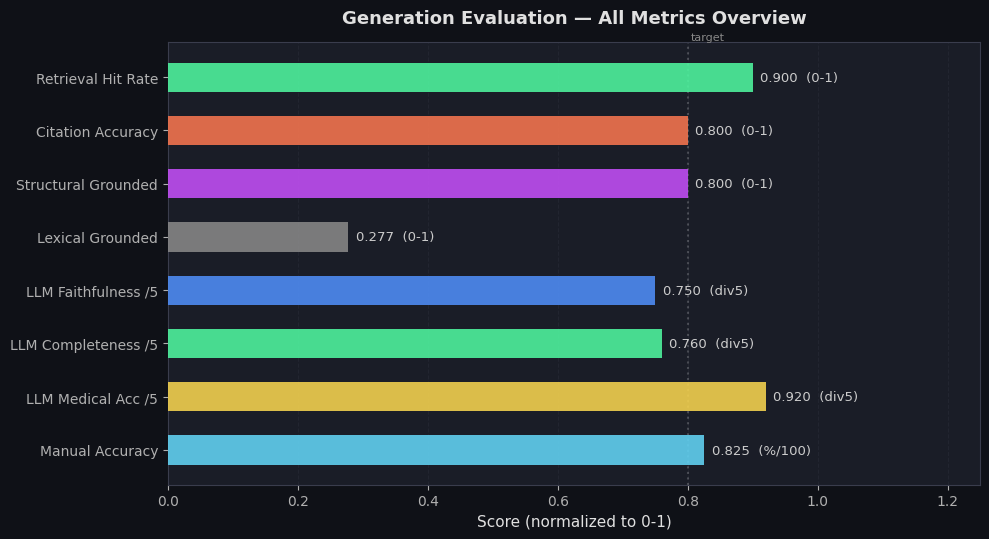

In [23]:
# ── Cell 10: Fig 1 — Overview Bar ─────────────────────────────────────────────
n = len(df)
metric_vals = [
    ('Retrieval Hit Rate',   df['retrieval_hit'].mean(),                      C_COMP,   '0-1'),
    ('Citation Accuracy',    df['citation_correct'].mean(),                   C_CITE,   '0-1'),
    ('Structural Grounded',  df['structural_grounded'].mean(),                C_GROUND, '0-1'),
    ('Lexical Grounded',     safe_mean(df['lexical_grounded']),               '#888888','0-1'),
    ('LLM Faithfulness /5',  safe_mean(df['llm_faithfulness']) / 5,          C_FAITH,  'div5'),
    ('LLM Completeness /5',  safe_mean(df['llm_completeness']) / 5,          C_COMP,   'div5'),
    ('LLM Medical Acc /5',   safe_mean(df['llm_medical_accuracy']) / 5,      C_MACC,   'div5'),
]
if manual_acc_pct is not None:
    metric_vals.append(('Manual Accuracy', manual_acc_pct / 100, C_MANUAL, '%/100'))

labels = [m[0] for m in metric_vals]
vals   = [m[1] for m in metric_vals]
colors = [m[2] for m in metric_vals]
scales = [m[3] for m in metric_vals]

fig, ax = plt.subplots(figsize=(10, 5.5))
bars = ax.barh(labels, vals, color=colors, alpha=0.88, height=0.55, zorder=3)
for bar, v, sc in zip(bars, vals, scales):
    if not (isinstance(v, float) and np.isnan(v)):
        ax.text(v + 0.012, bar.get_y() + bar.get_height()/2,
                f'{v:.3f}  ({sc})', va='center', fontsize=9.5, color='#cccccc')
ax.axvline(0.8, color='#ffffff', linestyle=':', alpha=0.2)
ax.text(0.805, -0.7, 'target', color='#888', fontsize=8)
ax.set_xlim(0, 1.25); ax.set_xlabel('Score (normalized to 0-1)')
ax.set_title('Generation Evaluation — All Metrics Overview', fontweight='bold', pad=14)
ax.grid(axis='x', zorder=0); ax.invert_yaxis()
plt.tight_layout()
if SAVE_FIGS: plt.savefig('figures_gen/fig1_overview.png', dpi=150, bbox_inches='tight', facecolor=DARK_BG)
plt.show()

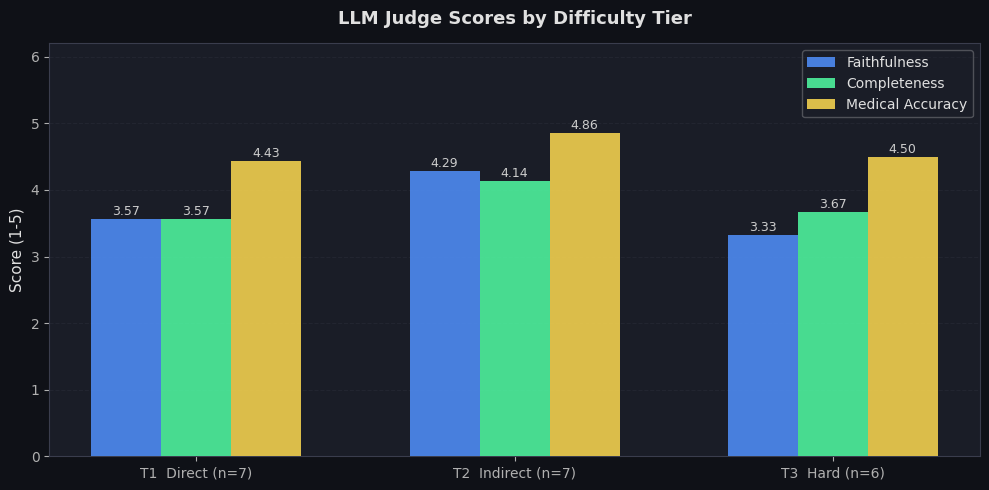

In [24]:
# ── Cell 11: Fig 2 — LLM Judge by Tier ────────────────────────────────────────
judge_metrics = ['llm_faithfulness','llm_completeness','llm_medical_accuracy']
jlabels = ['Faithfulness','Completeness','Medical Accuracy']
jcolors = [C_FAITH, C_COMP, C_MACC]
tier_judge_df = df.groupby('tier')[judge_metrics].mean().round(2).reindex([1,2,3])

x = np.arange(3); width = 0.22
fig, ax = plt.subplots(figsize=(10, 5))
for i, (metric, label, color) in enumerate(zip(judge_metrics, jlabels, jcolors)):
    offset = (i - 1) * width
    vals   = tier_judge_df[metric].values
    bars   = ax.bar(x + offset, vals, width, label=label, color=color, alpha=0.88, zorder=3)
    for bar, v in zip(bars, vals):
        if not np.isnan(v):
            ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.06,
                    f'{v:.2f}', ha='center', fontsize=9, color='#cccccc')
ax.set_xticks(x)
ax.set_xticklabels([f"T{t}  {TIER_NAMES[t].split('--')[0].split('--')[-1].split('--')[0].split('—')[-1].strip()} (n={tier_counts[t]})" for t in [1,2,3]], fontsize=10)
ax.set_ylim(0, 6.2); ax.set_ylabel('Score (1-5)')
ax.set_title('LLM Judge Scores by Difficulty Tier', fontweight='bold', pad=14)
ax.legend(fontsize=10); ax.grid(axis='y', zorder=0)
plt.tight_layout()
if SAVE_FIGS: plt.savefig('figures_gen/fig2_judge_by_tier.png', dpi=150, bbox_inches='tight', facecolor=DARK_BG)
plt.show()

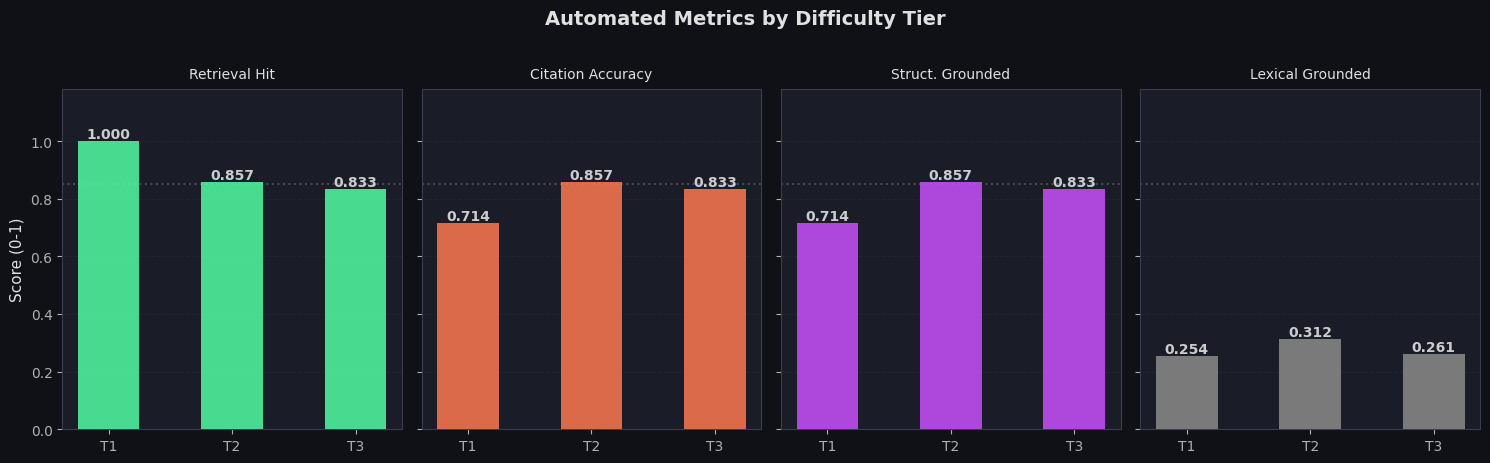

In [25]:
# ── Cell 12: Fig 3 — Auto Metrics by Tier ─────────────────────────────────────
auto_tier = df.groupby('tier')[['retrieval_hit','citation_correct','structural_grounded','lexical_grounded']].mean().round(3).reindex([1,2,3])
tier_xlabels = [f"T{t}" for t in [1,2,3]]

fig, axes = plt.subplots(1, 4, figsize=(15, 4.5), sharey=True)
fig.suptitle('Automated Metrics by Difficulty Tier', fontsize=14, fontweight='bold', y=1.02)
for ax, (col, title, color) in zip(axes, [
    ('retrieval_hit',       'Retrieval Hit',       C_COMP),
    ('citation_correct',    'Citation Accuracy',   C_CITE),
    ('structural_grounded', 'Struct. Grounded',    C_GROUND),
    ('lexical_grounded',    'Lexical Grounded',    '#888888'),
]):
    ax.set_facecolor(PANEL_BG)
    vals = auto_tier[col].values
    bars = ax.bar(tier_xlabels, vals, color=color, alpha=0.88, width=0.5, zorder=3)
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.012,
                f'{v:.3f}', ha='center', fontsize=10, fontweight='bold', color='#cccccc')
    ax.set_title(title, fontsize=10, pad=8)
    ax.set_ylim(0, 1.18)
    ax.set_ylabel('Score (0-1)' if ax == axes[0] else '')
    ax.axhline(0.85, color='#ffffff', linestyle=':', alpha=0.2)
    ax.grid(axis='y', zorder=0)
plt.tight_layout()
if SAVE_FIGS: plt.savefig('figures_gen/fig3_auto_by_tier.png', dpi=150, bbox_inches='tight', facecolor=DARK_BG)
plt.show()

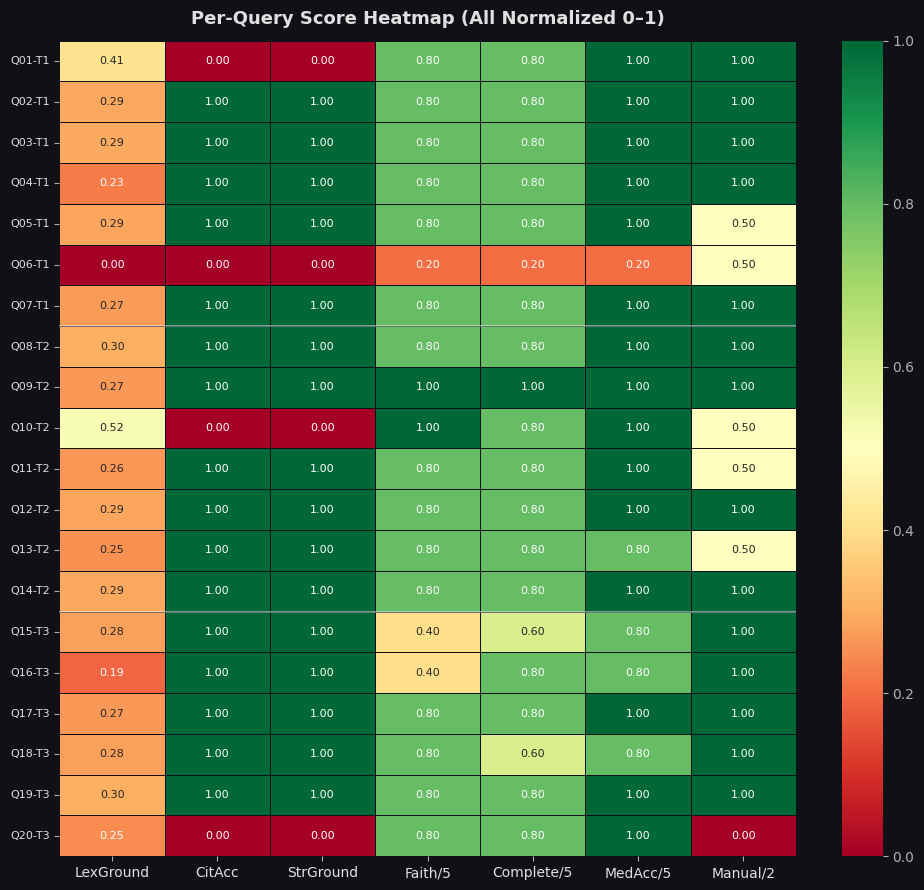

In [27]:
# ── Cell 13: Fig 4 — Per-Query Heatmap (Robust Version) ──────────────────────

# Select required columns safely
cols = [
    'id','tier',
    'lexical_grounded','citation_correct','structural_grounded',
    'llm_faithfulness','llm_completeness','llm_medical_accuracy',
    'manual_grade'
]

hm = df[cols].copy()

# Ensure numeric types (prevents float/int formatting issues)
hm['id'] = pd.to_numeric(hm['id'], errors='coerce').astype('Int64')
hm['tier'] = pd.to_numeric(hm['tier'], errors='coerce').astype('Int64')

metric_cols_5scale = [
    'llm_faithfulness','llm_completeness','llm_medical_accuracy'
]

# Normalize 5-scale metrics → 0–1
for col in metric_cols_5scale:
    hm[col] = pd.to_numeric(hm[col], errors='coerce') / 5.0

# Normalize manual grade (2-scale) only if exists
if hm['manual_grade'].notna().any():
    hm['manual_grade'] = pd.to_numeric(hm['manual_grade'], errors='coerce') / 2.0

# Create clean index labels (vectorized, safe)
hm.index = (
    "Q" + hm['id'].astype(int).map(lambda x: f"{x:02d}") +
    "-T" + hm['tier'].astype(int).astype(str)
)

# Drop id & tier after index creation
hm = hm.drop(columns=['id','tier'])

# Rename columns for display
hm.columns = [
    'LexGround','CitAcc','StrGround',
    'Faith/5','Complete/5','MedAcc/5','Manual/2'
]

# Convert everything to float for heatmap
hm = hm.astype(float)

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 9))

sns.heatmap(
    hm,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    linewidths=0.4,
    linecolor=DARK_BG,
    vmin=0.0,
    vmax=1.0,
    annot_kws={'size': 8},
    ax=ax
)

ax.set_title(
    'Per-Query Score Heatmap (All Normalized 0–1)',
    fontsize=13,
    pad=12,
    fontweight='bold',
    color=TEXT_COL
)

# Optional tier separators (for 20 queries grouped by 7/7/6)
for b in [7, 14]:
    ax.axhline(b, color='#ffffff', linewidth=1.5, alpha=0.4)

plt.setp(ax.get_xticklabels(), color=TEXT_COL, fontsize=10)
plt.setp(ax.get_yticklabels(), color=TEXT_COL, fontsize=8, rotation=0)

plt.tight_layout()

if SAVE_FIGS:
    plt.savefig(
        'figures_gen/fig4_heatmap.png',
        dpi=150,
        bbox_inches='tight',
        facecolor=DARK_BG
    )

plt.show()

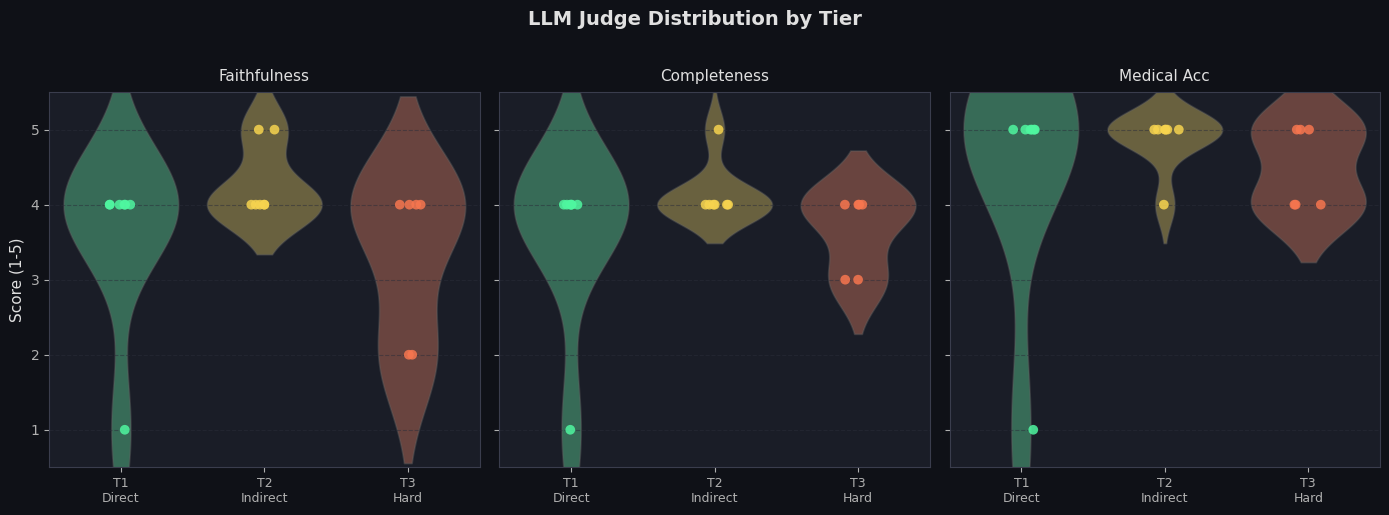

In [28]:
# ── Cell 14: Fig 5 — LLM Judge Distribution (Violin + Strip) ──────────────────
long = pd.melt(
    df[['tier_label','llm_faithfulness','llm_completeness','llm_medical_accuracy']].dropna(),
    id_vars='tier_label',
    value_vars=['llm_faithfulness','llm_completeness','llm_medical_accuracy'],
    var_name='metric', value_name='score'
)
long['metric'] = long['metric'].map({
    'llm_faithfulness':'Faithfulness','llm_completeness':'Completeness',
    'llm_medical_accuracy':'Medical Acc'
})
tier_order = list(TIER_NAMES.values())

fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
fig.suptitle('LLM Judge Distribution by Tier', fontsize=14, fontweight='bold', y=1.02)
for ax, metric_name in zip(axes, ['Faithfulness','Completeness','Medical Acc']):
    ax.set_facecolor(PANEL_BG)
    data = long[long['metric'] == metric_name]
    sns.violinplot(data=data, x='tier_label', y='score', order=tier_order,
                   palette=list(TIER_COLS.values()), inner=None, alpha=0.4, ax=ax)
    sns.stripplot(data=data, x='tier_label', y='score', order=tier_order,
                  palette=list(TIER_COLS.values()), size=7, jitter=True, alpha=0.85, ax=ax)
    ax.set_title(metric_name, fontsize=11, pad=8); ax.set_xlabel('')
    ax.set_ylabel('Score (1-5)' if ax == axes[0] else '')
    ax.set_ylim(0.5, 5.5); ax.set_yticks([1,2,3,4,5])
    ax.set_xticklabels(['T1\nDirect','T2\nIndirect','T3\nHard'], fontsize=9)
    ax.grid(axis='y', zorder=0)
plt.tight_layout()
if SAVE_FIGS: plt.savefig('figures_gen/fig5_judge_dist.png', dpi=150, bbox_inches='tight', facecolor=DARK_BG)
plt.show()

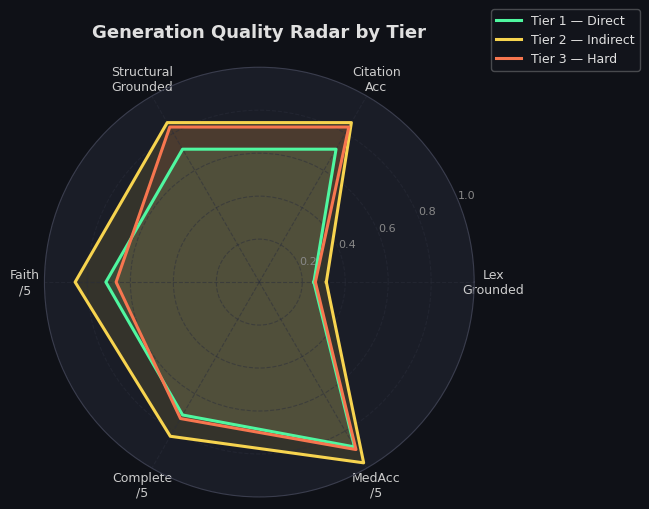

In [29]:
# ── Cell 15: Fig 6 — Radar by Tier ────────────────────────────────────────────
categories = ['Lex\nGrounded','Citation\nAcc','Structural\nGrounded','Faith\n/5','Complete\n/5','MedAcc\n/5']
N      = len(categories)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist() + [0]

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))
for t_id, color in TIER_COLS.items():
    td   = df[df['tier'] == t_id]
    vals = [
        safe_mean(td['lexical_grounded']),
        td['citation_correct'].mean(),
        td['structural_grounded'].mean(),
        safe_mean(td['llm_faithfulness']) / 5,
        safe_mean(td['llm_completeness']) / 5,
        safe_mean(td['llm_medical_accuracy']) / 5,
    ]
    vals = [0 if (isinstance(v, float) and np.isnan(v)) else v for v in vals]
    ax.plot(angles, vals + vals[:1], color=color, linewidth=2.2, label=TIER_NAMES[t_id])
    ax.fill(angles, vals + vals[:1], color=color, alpha=0.12)
ax.set_thetagrids(np.degrees(angles[:-1]), categories, fontsize=9, color='#cccccc')
ax.set_ylim(0, 1.0)
ax.set_yticks([0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels(['0.2','0.4','0.6','0.8','1.0'], fontsize=8, color='#888')
ax.grid(color=GRID_COL, linewidth=0.8)
ax.set_title('Generation Quality Radar by Tier', fontsize=13, pad=22, fontweight='bold')
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.15), fontsize=9)
ax.spines['polar'].set_color('#3a3d4d')
plt.tight_layout()
if SAVE_FIGS: plt.savefig('figures_gen/fig6_radar.png', dpi=150, bbox_inches='tight', facecolor=DARK_BG)
plt.show()

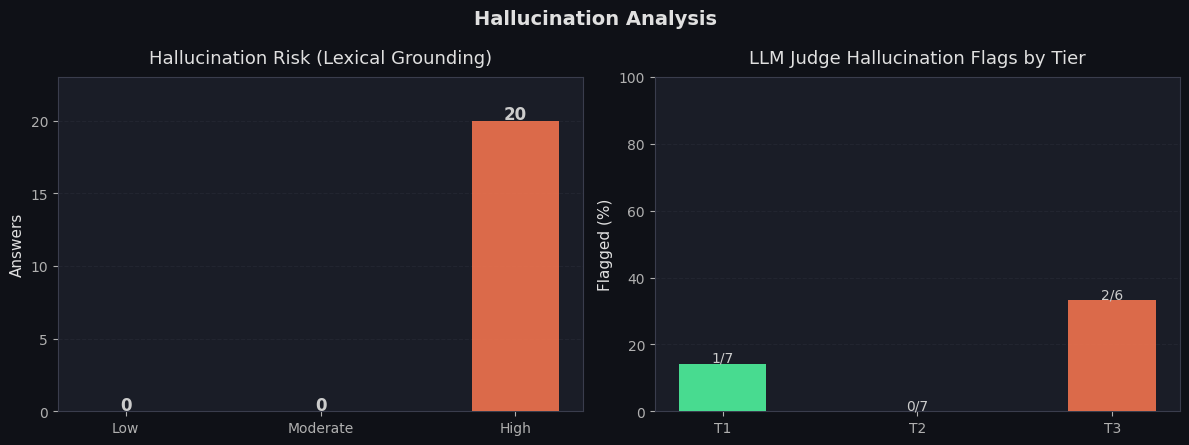

In [30]:
# ── Cell 16: Fig 7 — Hallucination Analysis ────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
fig.suptitle('Hallucination Analysis', fontsize=14, fontweight='bold')

ax = axes[0]; ax.set_facecolor(PANEL_BG)
risk_order  = ['Low','Moderate','High']
risk_colors = ['#4ff7a0','#f7d44f','#f7764f']
rc = [df['hallucination_risk'].value_counts().get(r, 0) for r in risk_order]
bars = ax.bar(risk_order, rc, color=risk_colors, alpha=0.88, width=0.45, zorder=3)
for bar, v in zip(bars, rc):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.1, str(v),
            ha='center', fontsize=12, fontweight='bold', color='#cccccc')
ax.set_title('Hallucination Risk (Lexical Grounding)', pad=10)
ax.set_ylabel('Answers'); ax.set_ylim(0, max(rc)+3); ax.grid(axis='y', zorder=0)

ax2 = axes[1]; ax2.set_facecolor(PANEL_BG)
jh = df[df['llm_hallucination_flag'].notna()]
if len(jh) > 0:
    th = jh.groupby('tier')['llm_hallucination_flag'].agg(['sum','count'])
    th['rate'] = th['sum'] / th['count'] * 100
    bars2 = ax2.bar([f'T{t}' for t in th.index], th['rate'],
                    color=[TIER_COLS[t] for t in th.index], alpha=0.88, width=0.45, zorder=3)
    for bar, (_, row) in zip(bars2, th.iterrows()):
        ax2.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5,
                 f"{int(row['sum'])}/{int(row['count'])}", ha='center', fontsize=10, color='#cccccc')
    ax2.set_title('LLM Judge Hallucination Flags by Tier', pad=10)
    ax2.set_ylabel('Flagged (%)'); ax2.set_ylim(0, 100); ax2.grid(axis='y', zorder=0)
plt.tight_layout()
if SAVE_FIGS: plt.savefig('figures_gen/fig7_hallucination.png', dpi=150, bbox_inches='tight', facecolor=DARK_BG)
plt.show()

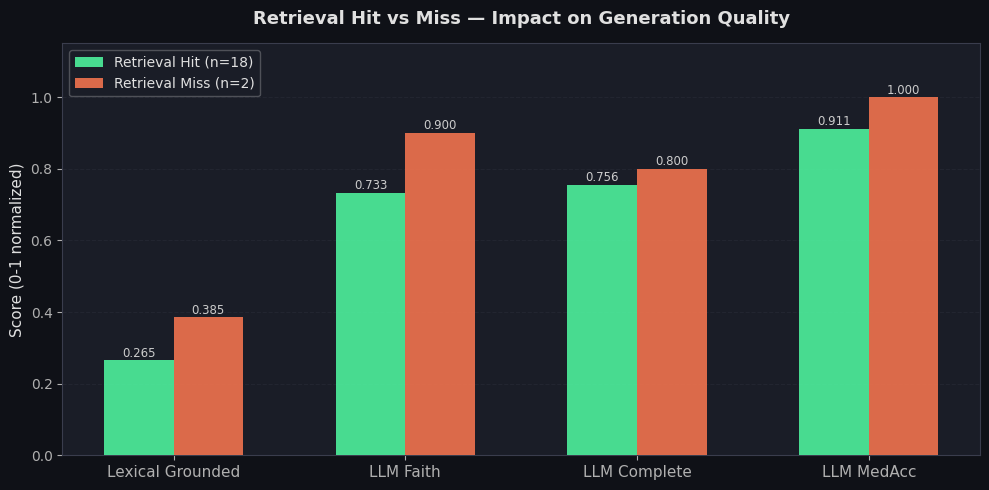

In [31]:
# ── Cell 17: Fig 8 — Retrieval Hit vs Miss Impact ─────────────────────────────
hit_df  = df[df['retrieval_hit'] == 1]
miss_df = df[df['retrieval_hit'] == 0]
compare = [
    ('lexical_grounded',   'Lexical Grounded', 1.0),
    ('llm_faithfulness',   'LLM Faith',        5.0),
    ('llm_completeness',   'LLM Complete',     5.0),
    ('llm_medical_accuracy','LLM MedAcc',      5.0),
]
labels    = [c[1] for c in compare]
hit_vals  = [safe_mean(hit_df[c[0]])  / c[2] for c in compare]
miss_vals = [safe_mean(miss_df[c[0]]) / c[2] for c in compare]

x = np.arange(len(labels)); width = 0.3
fig, ax = plt.subplots(figsize=(10, 5))
b1 = ax.bar(x-width/2, hit_vals,  width, label=f'Retrieval Hit (n={len(hit_df)})',  color='#4ff7a0', alpha=0.88, zorder=3)
b2 = ax.bar(x+width/2, miss_vals, width, label=f'Retrieval Miss (n={len(miss_df)})', color='#f7764f', alpha=0.88, zorder=3)
for bars, vals in [(b1,hit_vals),(b2,miss_vals)]:
    for bar, v in zip(bars, vals):
        if not (isinstance(v, float) and np.isnan(v)) and v > 0:
            ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01,
                    f'{v:.3f}', ha='center', fontsize=8.5, color='#cccccc')
ax.set_xticks(x); ax.set_xticklabels(labels, fontsize=11)
ax.set_ylim(0, 1.15); ax.set_ylabel('Score (0-1 normalized)')
ax.set_title('Retrieval Hit vs Miss — Impact on Generation Quality', fontweight='bold', pad=14)
ax.legend(fontsize=10); ax.grid(axis='y', zorder=0)
plt.tight_layout()
if SAVE_FIGS: plt.savefig('figures_gen/fig8_retrieval_gen_gap.png', dpi=150, bbox_inches='tight', facecolor=DARK_BG)
plt.show()

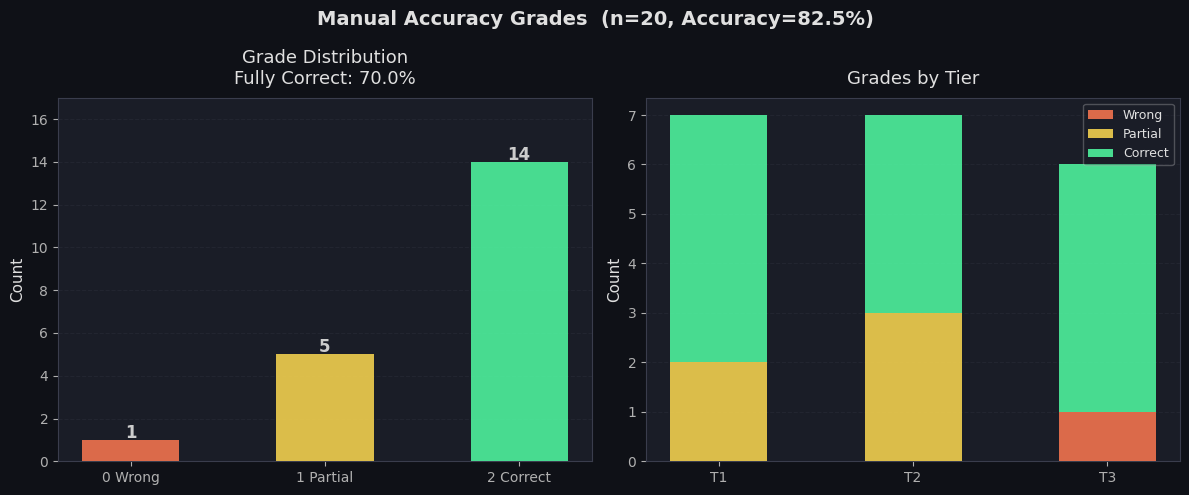

In [32]:
# ── Cell 18: Fig 9 — Manual Grades (if filled) ────────────────────────────────
if len(graded) == 0:
    print('No manual grades yet. Run: python evaluation/manual_grades.py')
else:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Manual Accuracy Grades  (n={len(graded)}, Accuracy={manual_acc_pct}%)', fontsize=14, fontweight='bold')

    ax = axes[0]; ax.set_facecolor(PANEL_BG)
    gc = graded['manual_grade'].value_counts().sort_index()
    bars = ax.bar(['0 Wrong','1 Partial','2 Correct'],
                  [gc.get(0,0), gc.get(1,0), gc.get(2,0)],
                  color=['#f7764f','#f7d44f','#4ff7a0'], alpha=0.88, width=0.5, zorder=3)
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x()+bar.get_width()/2, h+0.1, str(int(h)),
                ha='center', fontsize=12, fontweight='bold', color='#cccccc')
    ax.set_ylabel('Count'); ax.set_title(f'Grade Distribution\nFully Correct: {fully_correct_pct}%', pad=10)
    ax.set_ylim(0, max(gc.values)+3); ax.grid(axis='y', zorder=0)

    ax2 = axes[1]; ax2.set_facecolor(PANEL_BG)
    tg = graded.groupby(['tier','manual_grade']).size().unstack(fill_value=0)
    tg.index = [f"T{t}" for t in tg.index]
    bottom = np.zeros(len(tg))
    for gv, color, label in [(0,'#f7764f','Wrong'),(1,'#f7d44f','Partial'),(2,'#4ff7a0','Correct')]:
        vals = tg.get(gv, pd.Series([0]*len(tg))).values
        ax2.bar(tg.index, vals, bottom=bottom, color=color, alpha=0.88, label=label, width=0.5, zorder=3)
        bottom += vals
    ax2.set_ylabel('Count'); ax2.set_title('Grades by Tier', pad=10)
    ax2.legend(fontsize=9); ax2.grid(axis='y', zorder=0)
    plt.tight_layout()
    if SAVE_FIGS: plt.savefig('figures_gen/fig9_manual_grades.png', dpi=150, bbox_inches='tight', facecolor=DARK_BG)
    plt.show()

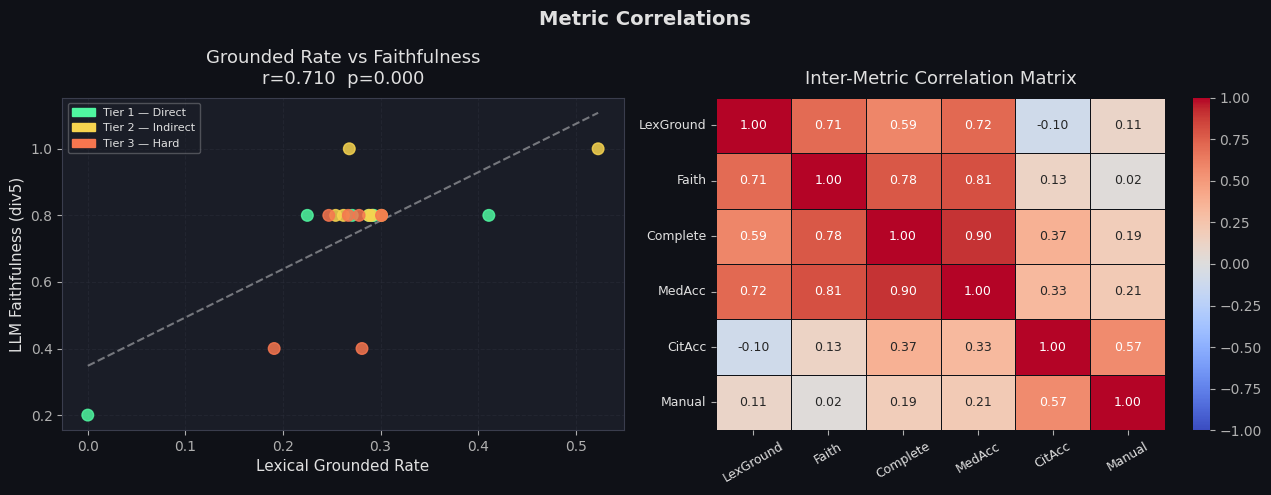

In [33]:
# ── Cell 19: Fig 10 — Correlation Analysis ────────────────────────────────────
corr_cols = ['lexical_grounded','llm_faithfulness','llm_completeness','llm_medical_accuracy','citation_correct']
if df['manual_grade'].notna().any():
    corr_cols.append('manual_grade')
corr_df = df[corr_cols].dropna()

if len(corr_df) >= 5:
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    fig.suptitle('Metric Correlations', fontsize=14, fontweight='bold')

    ax = axes[0]; ax.set_facecolor(PANEL_BG)
    sc_colors = [TIER_COLS[t] for t in df.loc[corr_df.index, 'tier']]
    ax.scatter(corr_df['lexical_grounded'], corr_df['llm_faithfulness']/5,
               c=sc_colors, s=70, alpha=0.85, zorder=3)
    z  = np.polyfit(corr_df['lexical_grounded'], corr_df['llm_faithfulness']/5, 1)
    xs = np.linspace(corr_df['lexical_grounded'].min(), corr_df['lexical_grounded'].max(), 50)
    ax.plot(xs, np.poly1d(z)(xs), color='#ffffff', linestyle='--', alpha=0.4, linewidth=1.5)
    r, pval = stats.pearsonr(corr_df['lexical_grounded'], corr_df['llm_faithfulness'])
    ax.set_xlabel('Lexical Grounded Rate'); ax.set_ylabel('LLM Faithfulness (div5)')
    ax.set_title(f'Grounded Rate vs Faithfulness\nr={r:.3f}  p={pval:.3f}', pad=10)
    patches = [mpatches.Patch(color=c, label=TIER_NAMES[t]) for t,c in TIER_COLS.items()]
    ax.legend(handles=patches, fontsize=8); ax.grid(zorder=0)

    ax2 = axes[1]
    rename_map = {'lexical_grounded':'LexGround','llm_faithfulness':'Faith',
                  'llm_completeness':'Complete','llm_medical_accuracy':'MedAcc',
                  'citation_correct':'CitAcc','manual_grade':'Manual'}
    cm = corr_df.rename(columns=rename_map).corr()
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1,
                linewidths=0.5, linecolor=DARK_BG, annot_kws={'size': 9}, ax=ax2)
    ax2.set_title('Inter-Metric Correlation Matrix', pad=10)
    plt.setp(ax2.get_xticklabels(), color=TEXT_COL, fontsize=9, rotation=30)
    plt.setp(ax2.get_yticklabels(), color=TEXT_COL, fontsize=9, rotation=0)
    plt.tight_layout()
    if SAVE_FIGS: plt.savefig('figures_gen/fig10_correlations.png', dpi=150, bbox_inches='tight', facecolor=DARK_BG)
    plt.show()

In [36]:
# ── Cell 20: Final Summary + Resume Numbers ────────────────────────────────────
gr = df['structural_grounded'].mean()
ca = df['citation_correct'].mean()
lg = safe_mean(df['lexical_grounded'])
fa = safe_mean(df['llm_faithfulness'])
co = safe_mean(df['llm_completeness'])
ma = safe_mean(df['llm_medical_accuracy'])
hf = int(df['llm_hallucination_flag'].sum()) if df['llm_hallucination_flag'].notna().any() else 'N/A'

W = 64
def row(label, val, W=W):
    s = f'  {label}: {val}'
    return f'|{s}{" "*(W-len(s))}|'

print('+' + '='*W + '+')
print(f'|  MediRAG Generation Evaluation — Final Report{" "*(W-46)}|')
print('+' + '='*W + '+')
print(f'|  AUTOMATED (n={len(df)})' + ' '*(W-17) + '|')
print(row('Structural Grounded', f'{gr:.3f}  ({gr*100:.1f}%)'))
print(row('Citation Accuracy',   f'{ca:.3f}  ({ca*100:.1f}%)'))
print(row('Hallucination Rate',  f'{1-gr:.3f}  ({(1-gr)*100:.1f}%)'))
print(row('Lexical Grounded',    f'{lg:.3f}'))
print('+' + '-'*W + '+')
print(f'|  LLM-AS-JUDGE ({JUDGE_MODEL})' + ' '*(W-17-len(JUDGE_MODEL)) + '|')
print(row('Faithfulness',        f'{fa:.2f} / 5.0'))
print(row('Completeness',        f'{co:.2f} / 5.0'))
print(row('Medical Accuracy',    f'{ma:.2f} / 5.0'))
print(row('Hallucination Flags', f'{hf}/20'))
if manual_acc_pct is not None:
    print('+' + '-'*W + '+')
    print(f'|  MANUAL GRADING (n={len(graded)})' + ' '*(W-22) + '|')
    print(row('Answer Accuracy',  f'{manual_acc_pct:.1f}%'))
    print(row('Fully Correct',    f'{fully_correct_pct:.1f}%'))
print('+' + '-'*W + '+')
rl = f'Evaluated 20 medical queries: grounding {gr:.0%}, faithfulness {fa:.1f}/5'
print(f'|  {rl}' + ' '*(W-2-len(rl)) + '|')
print('+' + '='*W + '+')

+================================================================+
|  MediRAG Generation Evaluation — Final Report                  |
+================================================================+
|  AUTOMATED (n=20)                                               |
|  Structural Grounded: 0.800  (80.0%)                           |
|  Citation Accuracy: 0.800  (80.0%)                             |
|  Hallucination Rate: 0.200  (20.0%)                            |
|  Lexical Grounded: 0.277                                       |
+----------------------------------------------------------------+
|  LLM-AS-JUDGE (llama-3.3-70b-versatile)                        |
|  Faithfulness: 3.75 / 5.0                                      |
|  Completeness: 3.80 / 5.0                                      |
|  Medical Accuracy: 4.60 / 5.0                                  |
|  Hallucination Flags: 3/20                                     |
+------------------------------------------------------------

In [35]:
# ── Cell 21: Export CSV ────────────────────────────────────────────────────────
import glob
df.drop(columns=['llm_reasoning'], errors='ignore').to_csv('medirag_generation_eval.csv', index=False)
print('Saved: medirag_generation_eval.csv')
if SAVE_FIGS:
    saved = sorted(glob.glob('figures_gen/fig*.png'))
    print(f'\n{len(saved)} figures saved to ./figures_gen/')
    for fp in saved: print(f'  {fp}')
print('\nGeneration evaluation complete.')

Saved: medirag_generation_eval.csv

10 figures saved to ./figures_gen/
  figures_gen\fig10_correlations.png
  figures_gen\fig1_overview.png
  figures_gen\fig2_judge_by_tier.png
  figures_gen\fig3_auto_by_tier.png
  figures_gen\fig4_heatmap.png
  figures_gen\fig5_judge_dist.png
  figures_gen\fig6_radar.png
  figures_gen\fig7_hallucination.png
  figures_gen\fig8_retrieval_gen_gap.png
  figures_gen\fig9_manual_grades.png

Generation evaluation complete.
